# Bioinformatics Workshop 2021
### Cascabel_S5_practice
### Running Cascabel pipeline with VSearch (OTU)
#### Maartje Brouwer
#### 2021 Feb 11
###### This notebook is running Python 3.6.7

#### Cascabel practice

In [1]:
## 1. Navigate to the BlackSea13 project under your user workshop dedicated directory
%cd /export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013

/export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013


In [2]:
## 2. Setup Cascabel 
#You can copy it from /export/data01/pipelines/CASCABEL
! cp -r /export/data01/pipelines/CASCABEL/ .
# cp -r copies an entire directory. the dot indicates copy in the current directory

## or clone it from GitHub
# git clone https://github/AlejandroAb/CASCABEL.git

In [3]:
# Go to CASCABEL directory
%cd CASCABEL

/export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/CASCABEL


##### background info
We are going to work with a subset of 200,000 reads with amplicon data from the Black Sea cruise. There are two different datasets belonging to the same samples, but PCR amplified with different primers: 
•	NIOZ101 -18S
o	Paired end – 2 x 300 
o	FW Primer: GCTTGTCTCAAAGATTAAGCC
o	RV Primer: CCTGCTGCCTTCCTTRGA
•	NIOZ102 -16S
o	Paired end – 2x300
o	FW Primer: GTGYCAGCMGCCGCGGTAA
o	RV Primer: GGACTACNVGGGTWTCTAAT
Select one of these two datasets to continue working for downstream steps.

###### I chose 18S for now, because it has unique barcodes on both forward and reverse

In [4]:
## 3. Activate Cascabel dependencies
# at ada
! source ~/.bashrc.conda3
! source activate qiime1
! export PATH=$PATH:/opt/biolinux/anaconda3/bin
! module load R/4.0.3
! unset LD_PRELOAD

# at YMGA
# ! source  ~/.zshrc.conda344

Anaconda is now active on server ada with base /opt/biolinux/anaconda3          python version : 3.6.7.final.0
Run "conda deactivate" command to deactivate and exit current python environment


##### Configuration files
As you can see, there are different configuration files on the CASCABEL directory. These configuration files, are already preconfigured for some specific workflows

config.asv.double_bc.yaml  ASV workflow for paired end data

config.asv.double_bc.unpaired.yaml ASV workflow for paired end data and “unpaired” reads.

config.asv.single_bc.yaml ASV workflow for single end data

config.otu.double_bc.yaml OTU workflow for paired end data

config.otu.double_bc.unpaired.yaml OTU workflow for paired end data and “unpaired” reads.

In [ ]:
#### 4. set-up a run for an OTU workflow using accordingly the dataset of your choice (I chose 18S)
Couldn't do this in Jupyter, but this is what I did in the terminal (MobaXterm)

! nano config.otu.double_bc.yaml

##### Changed the following

PROJECT: "BlackSea"

LIBRARY: ["NIOZ101"]

RUN: "Workshop_Test"

interactive : "T"

fw_reads: "/export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/Data/RawData/NIOZ101_1.fastq"
rv_reads: "/export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/Data/RawData/NIOZ101_2.fastq"
metadata: "/export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/ProjectInfo/NIOZ101/NIOZ101_18S_blackSea.txt"
#OR
input_files: ""

demultiplex: "T"
create_fastq_files: "T"
remove_bc: 12                                    # removes only the barcode
....
remove: "T"                                      # removes the primer
fw_primer: "GTGYCAGCMGCCGCGGTAA"
rv_primer: "GGACTACNVGGGTWTCTAAT"
min_overlap: "15"
extra_params: " --match-read-wildcards"

#The script for splitting the libraries tries to identify the correct Fastq file encoding (phred quality score) using information of the fastq file header. If this information is missing the script can fail. So make sure to include the correct phred offset (33)
split:
  q: "19"
  r: "5"
  barcode_type:  "24"
  extra_params: "--phred_offset 33" 

#Remove the primers using the cutadapt option match the wild cards on the primers and set a minimum overlap for the adapters to be found at 20 bp.
cutAdapters: "T"
cutadapt:
  command: "cutadapt"
  adapters: "-g GCTTGTCTCAAAGATTAAGCC...CCTGCTGCCTTCCTTRGA"
  extra_params: "--match-read-wildcards  -O 20"
#Important. Notice that the primers removed with the demultiplexing rule is applied only to create individual fastq files per sample, useful for uploading reads to public repositories and also is the input for dada2. While this rule is applied at a different stage for the OTU workflow. 

#Select vsearch as the taxonomy assignation method and select a database
Find the available databases at: http://redmine.nioz.nl/projects/pipeline-for-amplicon-analysis/wiki/Run#9-Databases.
For 515F_926R primers we recommend to use silva 138 for 515F-806R region
For F04_R22mod we recommend to use silva r138 for full-length sequences (you can also try other database like the protist ribosomal database).  
assignTaxonomy:
  tool: "vsearch"
…
vsearch:
   command: "vsearch"
   db_file: "/export/data01/databases/silva/qiime/SILVA_138_QIIME_release/sil$
   mapFile: "/export/data01/databases/silva/qiime/SILVA_138_QIIME_release/sil$
   identity: 0.8

#We don’t want to align the sequences for the moment so skip the alignment for the representative sequences
alignRep:
  align: "F"

#Filter observations (OTUs) from the OTU table with a minimum abundance of 5 and present at least on 2 different samples
filterOtu:
  n: "5"                                         # minimum abundance
  extra_params: "-s 2"                           # at least on 2 samples

###### In nano you can search patterns with ctrl + w
###### Save the file Ctrl + o (give it a new name, tell it yes as a different file)
Saved as config.otu_swarm.double_bc.N101.yaml
###### Exit nano with Ctrl + x

In [5]:
## 5. Create the directed acyclic graph (DAG) of the entire pipeline
# Send it to a svg file called OTU_WF_<clustering_method>.svg 
! snakemake --configfile config.otu_swarm.double_bc.NIOZ101.yaml --dag | dot -Tsvg > OTU_WF_swarm.svg 
# A DAG is a visual representation of the entire pipeline that will be run.

In [6]:
## 6. make a dry-run to see the commands and the number of rules that are going to be executed.
! snakemake --configfile config.otu_swarm.double_bc.NIOZ101.yaml -np
# -np makes it a dry-run, so you can check all steps. If everything is fine, repeat without -ng
## 7. The execution plan contains 65 rules (see bottom line)


rule init_structure:
    input: /export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/Data/RawData/NIOZ101_1.fastq, /export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/Data/RawData/NIOZ101_2.fastq, /export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/ProjectInfo/NIOZ101/NIOZ101_18S_blackSea.txt
    output: BlackSea/samples/NIOZ101/rawdata/fw.fastq, BlackSea/samples/NIOZ101/rawdata/rv.fastq, BlackSea/metadata/sampleList_mergedBarcodes_NIOZ101.txt
    jobid: 24
    wildcards: PROJECT=BlackSea, sample=NIOZ101

Scripts/init_sample.sh BlackSea NIOZ101 /export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/ProjectInfo/NIOZ101/NIOZ101_18S_blackSea.txt /export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/Data/RawData/NIOZ101_1.fastq /export/lv3/scratch/workshop_2021/Users/maartje/BlackSea_2013/Data/RawData/NIOZ101_2.fastq

rule fast_qc:
    input: BlackSea/samples/NIOZ101/rawdata/fw.fastq, BlackSea/samples/NIOZ101/rawdata/rv.fastq
    output: BlackSe

##### 8. Run the pipeline in a screen (so that it continues also when your pc is turned off)
screen -S vsearch
snakemake --configfile config.otu_swarm.double_bc.NIOZ101.yaml

You cannot continue in Jupyter

### First 3 messages during running the pipeline
something similar to this
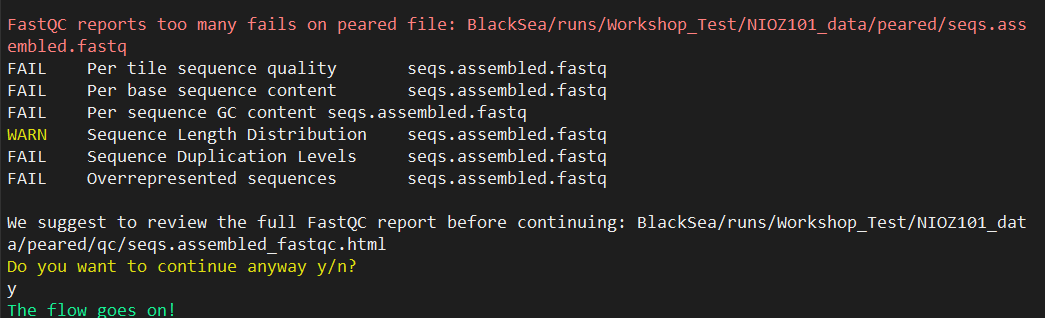

Answered Yes (FastQC is not the best option for QC of amplicon data, we should look for alternatives but haven't had time yet.)

### 4th message during running the pipeline
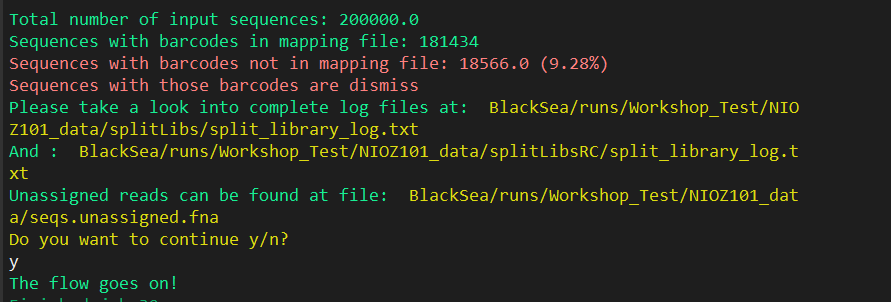
Answered Yes (% unassigned reads)

### 9. Cascabel will stop at the length filtering step (rule: remove_short_long_reads).
Print the sequence length histogram
adjust the minimum and maximum values to include sequences with at least 50 reps according to their length.
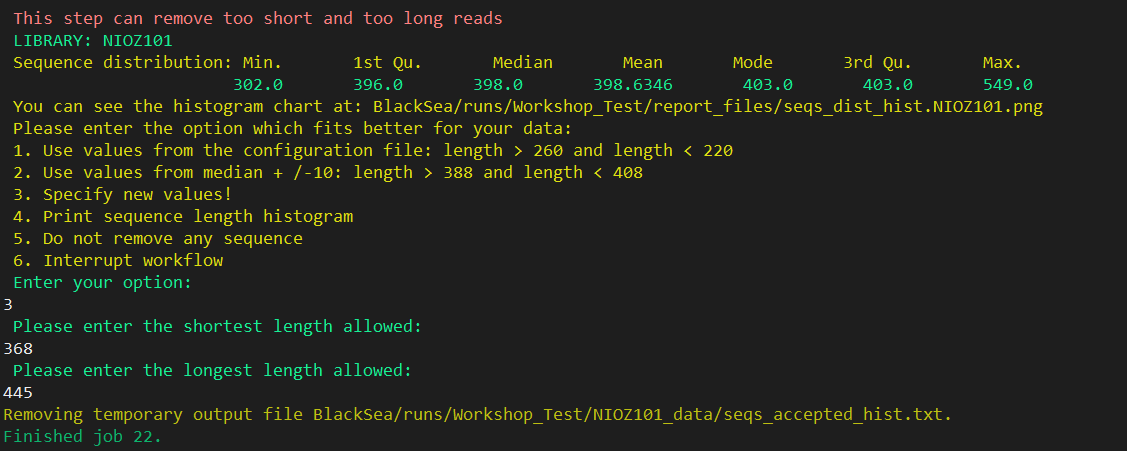

### 10. Once that your run is finished, locate the report “report_vsearch.zip” 
transfer that file to your computer --> C:\Users\dnalab\Desktop\unix_workshop\Cascabel\report_vsearch.zip
exit server. go to directory

! cd /home/mobaxterm/Desktop/unix_workshop/Cascabel

Un-compress the file and inspect the report

! unzip report_vsearch.zip

### the output file structure 
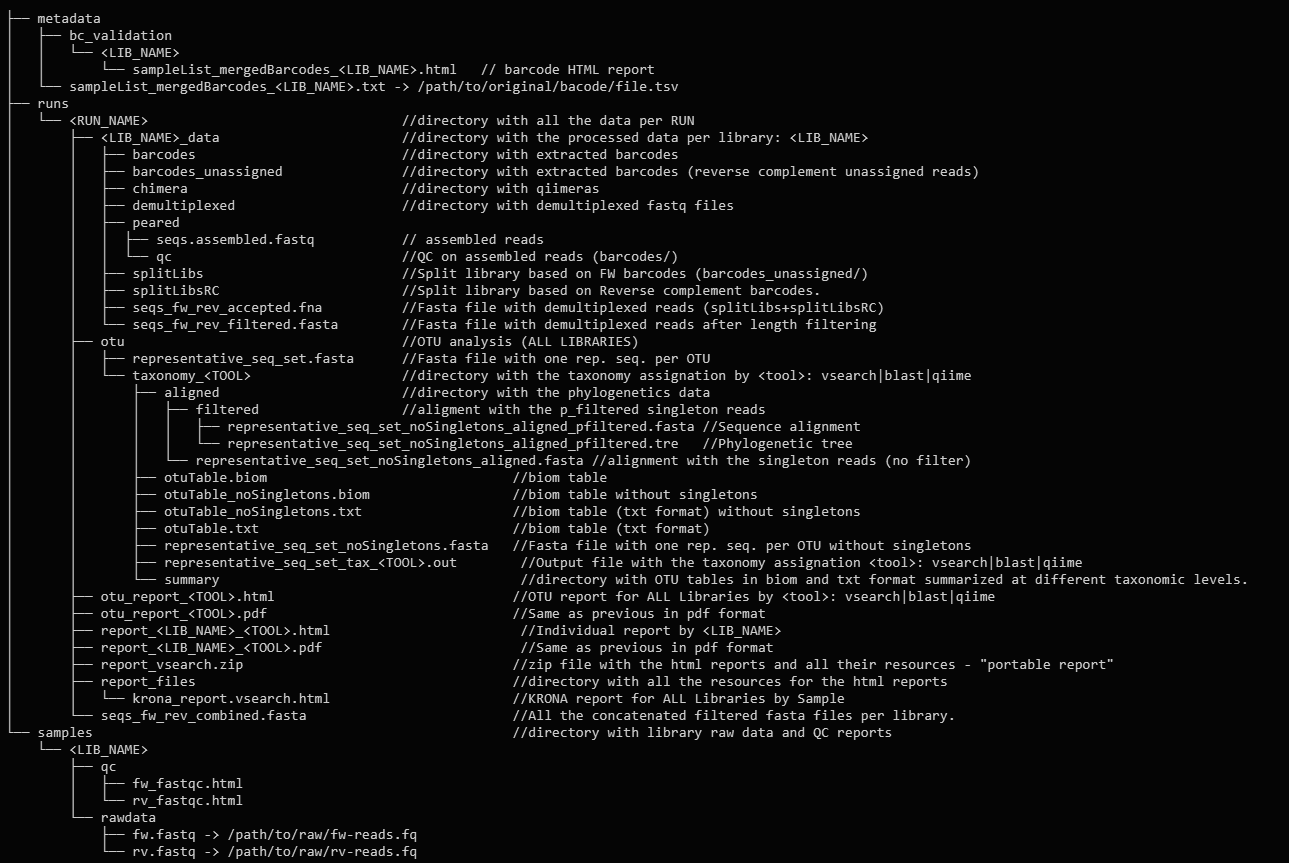